In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 16

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Dark2")

In [32]:
data=pd.read_csv('2011fe_photometry.csv')

In [33]:
data['band'].unique()

array(['g', "g'", 'UVW1', 'U', 'B', 'UVW2', 'V', 'UVM2', 'I', 'R', 'r',
       'Rc', 'Ic', 'H', 'K', 'J', '1', '2', 'I1', 'I2'], dtype=object)

In [34]:
bands=['UVW1','UVW2','UVM2','U','B','V','I','R','Rc','Ic']

In [35]:
band=data[data['band']=='B']
band=band[band['e_magnitude']<=0.1]

#band['source'].unique()

#band=band[band['source']=='2013CoSka..43...94T,Sternberg Astronomical Institute Supernova Light Curve Catalogue']

In [36]:
band

,event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
105,SN2011fe,55797.9261,15.585,0.052,F,B,UVOT,Swift,2014Ap&SS.354...89B
111,SN2011fe,55797.9930,15.427,0.048,F,B,UVOT,Swift,2014Ap&SS.354...89B
116,SN2011fe,55798.1700,15.206,0.016,F,B,NaN,kait4,2012MNRAS.425.1789S
129,SN2011fe,55798.8500,14.330,0.030,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
133,SN2011fe,55798.8800,14.360,0.030,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
...,...,...,...,...,...,...,...,...,...
3378,SN2011fe,56152.8000,17.920,0.080,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
3391,SN2011fe,56154.7600,17.690,0.050,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
3446,SN2011fe,56193.7300,18.160,0.050,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
3451,SN2011fe,56198.7000,18.300,0.080,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."


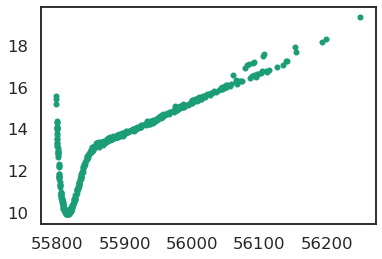

In [37]:
band=data[data['band']=="B"]
band=band[band['e_magnitude']<=0.1]
plt.scatter(band['time'],band['magnitude'],marker='.')


In [38]:

from george.modeling import Model
class MeanModel(Model):
    parameter_names=('a1','b1','c1','a2','b2','c2','tsep')
    
    def get_value(self,t):
        flux=np.zeros(len(t))
        
        ind =np.argmin(np.abs(t-self.tsep))
        
        flux[0:ind]=self.a1*t[0:ind]**2+self.b1*t[0:ind]+self.c1
        flux[ind:]=self.a2*t[ind:]**2+self.b2*t[ind:]+self.c2
        
        return flux

In [39]:
from george import kernels

kernel=kernels.ExpSquaredKernel(50.0)


In [40]:
np.argmin(np.abs(band['time']-55840))

166

In [41]:
a10,b10,c10=np.polyfit(band['time'][0:160],band['magnitude'][0:160],deg=2)

In [42]:
a20,b20,c20=np.polyfit(band['time'][160:],band['magnitude'][160:],deg=2)

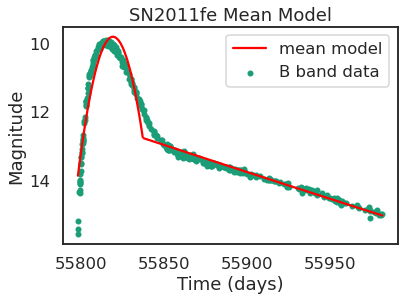

In [43]:
plt.scatter(band['time'][0:400],band['magnitude'][0:400],marker='.',label='B band data')

plt.plot(band['time'][0:159],a10*band['time'][0:159]**2+b10*band['time'][0:159]+c10,'r',label='mean model')

plt.plot(band['time'][160:400],a20*band['time'][160:400]**2+b20*band['time'][160:400]+c20,'r')


plt.title('SN2011fe Mean Model')
plt.ylabel('Magnitude')
plt.xlabel('Time (days)')
plt.legend()

plt.gca().invert_yaxis()


In [44]:
def lnprob(p):
    model.set_parameter_vector(p) 
    return -model.lnlikelihood(band["magnitude"], quiet=True)

In [45]:
time = band['time']
mag = band['magnitude']

In [46]:
import scipy.optimize as op
import george
#model = george.GP(kernel=kernel,mean=m0)
global model

tsep0=55830

model = george.GP(kernel = kernel, mean = MeanModel(a10,b10,c10,a20,b20,c20,tsep0))

model.compute(time)

p0 = model.get_parameter_vector()
results = op.minimize(lnprob, p0, method="L-BFGS-B")

t_new = np.linspace(np.min(time),np.max(time), 400)

ypred,cov= model.predict(mag, t_new)


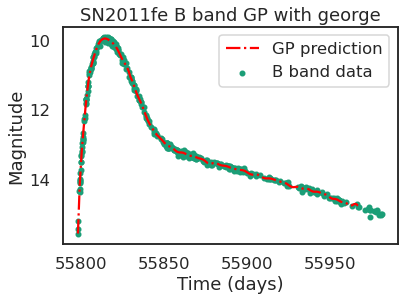

In [47]:
plt.plot(t_new[0:150],ypred[0:150],c='r',ls='-.',label='GP prediction')
plt.scatter(time[0:400],mag[0:400],marker='.',label='B band data')
plt.gca().invert_yaxis()

plt.title('SN2011fe B band GP with george')
plt.ylabel('Magnitude')
plt.xlabel('Time (days)')
plt.legend()

In [48]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt
from pymc3.gp.util import plot_gp_dist

In [49]:
time = band['time'][0:400]
mag = band['magnitude'][0:400]

In [50]:
class MeanModel(pm.gp.mean.Mean):
    def __init__(self, a1, b1, c1, a2, b2, c2, tsep):
        self.a1 = a1
        self.b1 = b1
        self.c1 = c1
        self.a2 = a2
        self.b2 = b2
        self.c2 = c2
        self.tsep = tsep
    def __call__(self, t):
        
        #ind=np.argmin(np.abs(t-self.tsep))
        
        time1 = t[t<=tsep0]
        time2 = t[t>tsep0]
        mag1 = self.a1*time1**2 + self.b1*time1 + self.c1
        mag2 = self.a2*time2**2 + self.b2*time2 + self.c2
        mean = tt.concatenate([mag1,mag2])
        return mean

In [51]:
with pm.Model() as marginal_gp_model:
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=3.0)
    
    a11 = pm.Normal('a1', a10, sigma=0.1*a10, shape=1)
    b11 = pm.Normal('b1', b10, sigma=0.1*b10, shape=1)
    c11 = pm.Normal('c1', c10, sigma=0.1*c10, shape=1)
    a21 = pm.Normal('a2', a20, sigma=0.1*a20, shape=1)
    b21 = pm.Normal('b2', b20, sigma=0.1*b20, shape=1)
    c21 = pm.Normal('c2', c20, sigma=0.1*c20, shape=1)
    tsep1 = pm.Normal('tsep', tsep0, sigma=10, shape=1)

    mean_func = MeanModel(a1=a11, b1=b11, c1=c11, a2=a21, b2=b21, c2=c21, tsep=tsep1)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    y_ = gp.marginal_likelihood("mag", X=band['time'][:, None], y=band['magnitude'].values, noise=0.1)
    mp = pm.find_MAP()

/home/thirty-oner/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -inf, ||grad|| = 8.2519e+11: 100%|██████████| 4/4 [00:00<00:00, 699.58it/s]


In [52]:
# new values from x=0 to x=100
X_new = np.linspace(np.min(time), np.max(time), 100)[:, None]

print(X_new.shape)

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=50)

(100, 1)


100%|██████████| 50/50 [00:03<00:00, 12.62it/s]


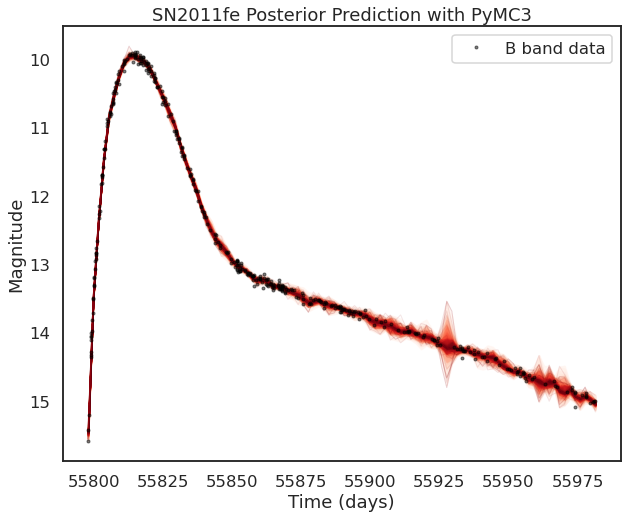

In [53]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)
plt.plot(time, mag, 'ok', ms=3, alpha=0.5, label="B band data")
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')
plt.title('SN2011fe Posterior Prediction with PyMC3')
plt.legend()

In [54]:
bands

['UVW1', 'UVW2', 'UVM2', 'U', 'B', 'V', 'I', 'R', 'Rc', 'Ic']

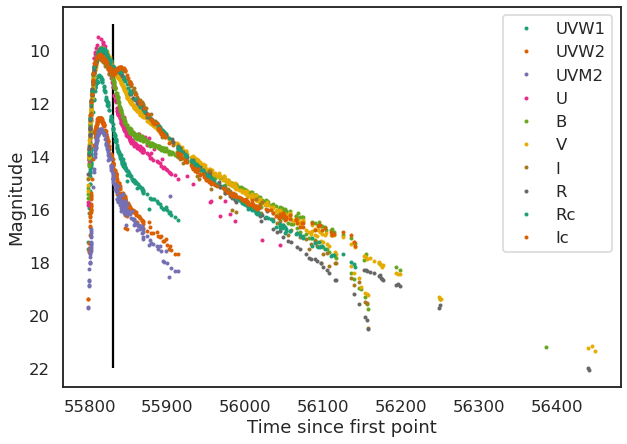

In [55]:
fig = plt.figure(figsize=(10, 7))
for idx, val in enumerate(bands):
    plt.plot(data[data['band']==val]['time'], data[data['band']==val]['magnitude'], 'o', ms=3, label=val)
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')

plt.vlines(x=55830,ymin=9,ymax=22)

plt.gca().invert_yaxis()
plt.legend()
plt.show()



In [56]:
UVW1band=data[data['band']=='UVW1']
UVW2band=data[data['band']=='UVW2']
UVM2band=data[data['band']=='UVM2']
Uband=data[data['band']=='U']
Bband=data[data['band']=='B']
Vband=data[data['band']=='V']
Iband=data[data['band']=='I']
Rband=data[data['band']=='R']
Rcband=data[data['band']=='Rc']
Icband=data[data['band']=='Ic']

t1=55800
t2=t1+60

UVW1band=UVW1band[UVW1band['time']>t1]
UVW2band=UVW2band[UVW2band['time']>t1]
UVM2band=UVM2band[UVM2band['time']>t1]
Uband=Uband[Uband['time']>t1]
Bband=Bband[Bband['time']>t1]
Vband=Vband[Vband['time']>t1]
Iband=Iband[Iband['time']>t1]
Rband=Rband[Rband['time']>t1]
Rcband=Rcband[Rcband['time']>t1]
Icband=Icband[Icband['time']>t1]

UVW1band=UVW1band[UVW1band['time']<=t2]
UVW2band=UVW2band[UVW2band['time']<=t2]
UVM2band=UVM2band[UVM2band['time']<=t2]
Uband=Uband[Uband['time']<=t2]
Bband=Bband[Bband['time']<=t2]
Vband=Vband[Vband['time']<=t2]
Iband=Iband[Iband['time']<=t2]
Rband=Rband[Rband['time']<=t2]
Rcband=Rcband[Rcband['time']<=t2]
Icband=Icband[Icband['time']<=t2]

UVW1band=UVW1band[UVW1band['e_magnitude']<=0.1]
UVW2band=UVW2band[UVW2band['e_magnitude']<=0.1]
UVM2band=UVM2band[UVM2band['e_magnitude']<=0.1]
Uband=Uband[Uband['e_magnitude']<=0.1]
Bband=Bband[Bband['e_magnitude']<=0.1]
Vband=Vband[Vband['e_magnitude']<=0.1]
Rcband=Rcband[Rcband['e_magnitude']<=0.1]
Iband=Iband[Iband['e_magnitude']<=0.1]
Rband=Rband[Rband['e_magnitude']<=0.1]
Icband=Icband[Icband['e_magnitude']<=0.1]

In [61]:
tsep0=55840

In [103]:
with pm.Model() as hierarchical_model:
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=6.0)
    
    a11 = pm.Normal('a1', a10, sigma=1*a10, shape=len(bands))
    b11 = pm.Normal('b1', b10, sigma=1*b10, shape=len(bands))
    c11 = pm.Normal('c1', c10, sigma=1*c10, shape=len(bands))
    a21 = pm.Normal('a2', a20, sigma=1*a20, shape=len(bands))
    b21 = pm.Normal('b2', b20, sigma=1*b20, shape=len(bands))
    c21 = pm.Normal('c2', c20, sigma=1*c20, shape=len(bands))
    tsep1 = pm.Normal('tsep', tsep0, sigma=10, shape=len(bands))

    mean_func1 = MeanModel(a1=a11[0], b1=b11[0], c1=c11[0], a2=a21[0], b2=b21[0], c2=c21[0], tsep=tsep1)
    gp1 = pm.gp.Marginal(mean_func=mean_func1, cov_func=cov_func)
    y1_ = gp1.marginal_likelihood("mag1", X=UVW1band['time'][:, None], y=UVW1band['magnitude'].values, noise=0.1)
    mp1 = pm.find_MAP()
    
    mean_func2 = MeanModel(a1=a11[1], b1=b11[1], c1=c11[1], a2=a21[1], b2=b21[1], c2=c21[1], tsep=tsep1)
    gp2 = pm.gp.Marginal(mean_func=mean_func2, cov_func=cov_func)
    y2_ = gp2.marginal_likelihood("mag2", X=UVW2band['time'][:, None], y=UVW2band['magnitude'].values, noise=0.1)
    mp2 = pm.find_MAP()
    
    mean_func3 = MeanModel(a1=a11[2], b1=b11[2], c1=c11[2], a2=a21[2], b2=b21[2], c2=c21[2], tsep=tsep1)
    gp3 = pm.gp.Marginal(mean_func=mean_func3, cov_func=cov_func)
    y3_ = gp3.marginal_likelihood("mag3", X=UVM2band['time'][:, None], y=UVM2band['magnitude'].values, noise=0.1)
    mp3 = pm.find_MAP()
    
    mean_func4 = MeanModel(a1=a11[3], b1=b11[3], c1=c11[3], a2=a21[3], b2=b21[3], c2=c21[3], tsep=tsep1)
    gp4 = pm.gp.Marginal(mean_func=mean_func4, cov_func=cov_func)
    y4_ = gp4.marginal_likelihood("mag4", X=Uband['time'][:, None], y=Uband['magnitude'].values, noise=0.1)
    mp4 = pm.find_MAP()
    
    mean_func5 = MeanModel(a1=a11[4], b1=b11[4], c1=c11[4], a2=a21[4], b2=b21[4], c2=c21[4], tsep=tsep1)
    gp5 = pm.gp.Marginal(mean_func=mean_func5, cov_func=cov_func)
    y5_ = gp5.marginal_likelihood("mag5", X=Bband['time'][:, None], y=Bband['magnitude'].values, noise=0.1)
    mp5 = pm.find_MAP()
    
    mean_func6 = MeanModel(a1=a11[5], b1=b11[5], c1=c11[5], a2=a21[5], b2=b21[5], c2=c21[5], tsep=tsep1)
    gp6 = pm.gp.Marginal(mean_func=mean_func6, cov_func=cov_func)
    y6_ = gp6.marginal_likelihood("mag6", X=Vband['time'][:, None], y=Vband['magnitude'].values, noise=0.1)
    mp6 = pm.find_MAP()
    
    mean_func7 = MeanModel(a1=a11[6], b1=b11[6], c1=c11[6], a2=a21[6], b2=b21[6], c2=c21[6], tsep=tsep1)
    gp7 = pm.gp.Marginal(mean_func=mean_func7, cov_func=cov_func)
    y7_ = gp7.marginal_likelihood("mag7", X=Iband['time'][:, None], y=Iband['magnitude'].values, noise=0.1)
    mp7 = pm.find_MAP()
    
    mean_func8 = MeanModel(a1=a11[7], b1=b11[7], c1=c11[7], a2=a21[7], b2=b21[7], c2=c21[7], tsep=tsep1)
    gp8 = pm.gp.Marginal(mean_func=mean_func8, cov_func=cov_func)
    y8_ = gp8.marginal_likelihood("mag8", X=Rband['time'][:, None], y=Rband['magnitude'].values, noise=0.1)
    mp8 = pm.find_MAP()
    
    mean_func9 = MeanModel(a1=a11[8], b1=b11[8], c1=c11[8], a2=a21[8], b2=b21[8], c2=c21[8], tsep=tsep1)
    gp9 = pm.gp.Marginal(mean_func=mean_func9, cov_func=cov_func)
    y9_ = gp9.marginal_likelihood("mag9", X=Rcband['time'][:, None], y=Rcband['magnitude'].values, noise=0.1)
    mp9 = pm.find_MAP()
    
    mean_func10 = MeanModel(a1=a11[9], b1=b11[9], c1=c11[9], a2=a21[9], b2=b21[9], c2=c21[9], tsep=tsep1)
    gp10 = pm.gp.Marginal(mean_func=mean_func10, cov_func=cov_func)
    y10_ = gp10.marginal_likelihood("mag10", X=Icband['time'][:, None], y=Icband['magnitude'].values, noise=0.1)
    mp10 = pm.find_MAP()

/home/thirty-oner/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -inf, ||grad|| = 6.6555e+11: 100%|██████████| 4/4 [00:00<00:00, 1249.61it/s]
/home/thirty-oner/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -inf, ||grad|| = 7.7298e+11: 100%|██████████| 4/4 [00:00<00:00, 1005.17it/s]
/home/thirty-oner/anaconda3/lib/python3.7/site-packages/thea

In [104]:
X_new = np.linspace(t1,t2, 50)[:, None]

with hierarchical_model:
    f_pred0 = gp1.conditional("f_pred0", X_new)
    f_pred1 = gp2.conditional("f_pred1", X_new)
    f_pred2 = gp3.conditional("f_pred2", X_new)
    f_pred3 = gp4.conditional("f_pred3", X_new)
    f_pred4 = gp5.conditional("f_pred4", X_new)
    f_pred5 = gp6.conditional("f_pred5", X_new)
    f_pred6 = gp7.conditional("f_pred6", X_new)
    f_pred7 = gp8.conditional("f_pred7", X_new)
    f_pred8 = gp9.conditional("f_pred8", X_new)
    f_pred9 = gp10.conditional("f_pred9", X_new)

with hierarchical_model:
    pred_samples0 = pm.sample_posterior_predictive([mp1], vars=[f_pred0], samples=100)
    pred_samples1 = pm.sample_posterior_predictive([mp2], vars=[f_pred1], samples=100)
    pred_samples2 = pm.sample_posterior_predictive([mp3], vars=[f_pred2], samples=100)
    pred_samples3 = pm.sample_posterior_predictive([mp4], vars=[f_pred3], samples=100)
    pred_samples4 = pm.sample_posterior_predictive([mp5], vars=[f_pred4], samples=100)
    pred_samples5 = pm.sample_posterior_predictive([mp6], vars=[f_pred5], samples=100)
    pred_samples6 = pm.sample_posterior_predictive([mp7], vars=[f_pred6], samples=100)
    pred_samples7 = pm.sample_posterior_predictive([mp8], vars=[f_pred7], samples=100)
    pred_samples8 = pm.sample_posterior_predictive([mp9], vars=[f_pred8], samples=100)
    pred_samples9 = pm.sample_posterior_predictive([mp10], vars=[f_pred9], samples=100)

100%|██████████| 100/100 [00:01<00:00, 57.19it/s]


Text(0.5, 1.0, 'Posterior distribution over all bands')

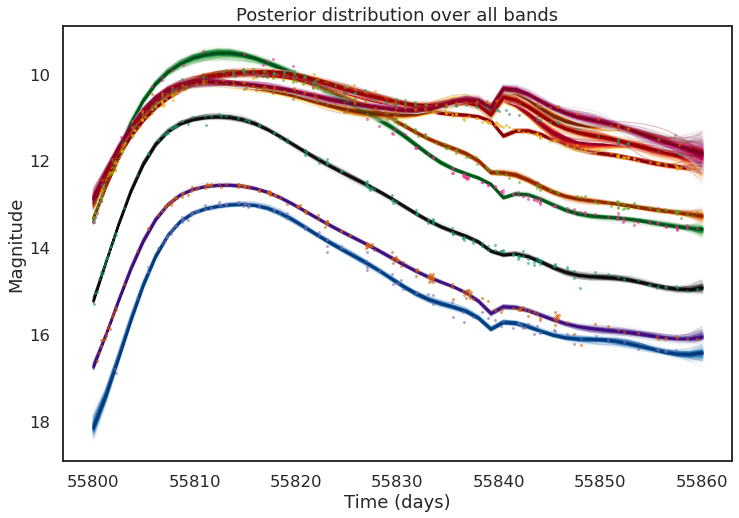

In [105]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
plot_gp_dist(ax, pred_samples0["f_pred0"], X_new, palette = 'Greys')
plt.plot(UVW1band['time'], UVW1band['magnitude'], 'o', ms=2, alpha=0.5, label="UVW1")
plot_gp_dist(ax, pred_samples1["f_pred1"], X_new, palette = 'Purples')
plt.plot(UVW2band['time'], UVW2band['magnitude'], 'o', ms=2, alpha=0.5, label="UVW2")
plot_gp_dist(ax, pred_samples2["f_pred2"], X_new, palette = 'Blues')
plt.plot(UVM2band['time'], UVM2band['magnitude'], 'o', ms=2, alpha=0.5, label="UVM2")
plot_gp_dist(ax, pred_samples3["f_pred3"], X_new, palette = 'Greens')
plt.plot(Uband['time'], Uband['magnitude'], 'o', ms=2, alpha=0.5, label="U")
plot_gp_dist(ax, pred_samples4["f_pred4"], X_new, palette = 'Oranges')
plt.plot(Bband['time'], Bband['magnitude'], 'o', ms=2, alpha=0.5, label="B")
plot_gp_dist(ax, pred_samples5["f_pred5"], X_new, palette = 'Reds')
plt.plot(Vband['time'], Vband['magnitude'], 'o', ms=2, alpha=0.5, label="V")
plot_gp_dist(ax, pred_samples6["f_pred6"], X_new, palette = 'YlOrBr')
plt.plot(Iband['time'], Iband['magnitude'], 'o', ms=2, alpha=0.5, label="I")
plot_gp_dist(ax, pred_samples7["f_pred7"], X_new, palette = 'YlOrRd')
plt.plot(Rband['time'], Rband['magnitude'], 'o', ms=2, alpha=0.5, label="R")
plot_gp_dist(ax, pred_samples8["f_pred8"], X_new, palette = 'OrRd')
plt.plot(Rcband['time'], Rcband['magnitude'], 'o', ms=2, alpha=0.5, label="Rc")
plot_gp_dist(ax, pred_samples9["f_pred9"], X_new, palette = 'PuRd')
plt.plot(Icband['time'], Icband['magnitude'], 'o', ms=2, alpha=0.5, label="Ic")

plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')
plt.title('Posterior distribution over all bands')

#plt.legend()

In [107]:
lcUVW1 = np.median(pred_samples0['f_pred0'], axis=0)
lcUVW2 = np.median(pred_samples1['f_pred1'], axis=0)
lcUVM2 = np.median(pred_samples2['f_pred2'], axis=0)
lcU = np.median(pred_samples3['f_pred3'], axis=0)
lcB = np.median(pred_samples4['f_pred4'], axis=0)
lcV = np.median(pred_samples5['f_pred5'], axis=0)
lcI = np.median(pred_samples6['f_pred6'], axis=0)
lcR = np.median(pred_samples7['f_pred7'], axis=0)
lcRc = np.median(pred_samples8['f_pred8'], axis=0)
lcIc = np.median(pred_samples9['f_pred9'], axis=0)

stdUVW1 = np.std(pred_samples0['f_pred0'], axis=0)
stdUVW2 = np.std(pred_samples1['f_pred1'], axis=0)
stdUVM2 = np.std(pred_samples2['f_pred2'], axis=0)
stdU = np.std(pred_samples3['f_pred3'], axis=0)
stdB = np.std(pred_samples4['f_pred4'], axis=0)
stdV = np.std(pred_samples5['f_pred5'], axis=0)
stdI = np.std(pred_samples6['f_pred6'], axis=0)
stdR = np.std(pred_samples7['f_pred7'], axis=0)
stdRc = np.std(pred_samples8['f_pred8'], axis=0)
stdIc = np.std(pred_samples9['f_pred9'], axis=0)

bol_std=np.sqrt(stdUVW1**2+stdUVW2**2+stdUVM2**2+stdU**2+stdB**2+stdV**2+stdI**2+stdR**2)

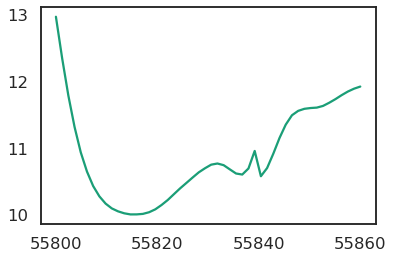

In [108]:
plt.plot(X_new,lcR)

In [109]:
wavelengths = np.array([291,212,231,344,450,543,806,658])*10 #in Angstroms
c = 3e18

bol = []
bolerr = []
flux_arr = []
magserr_arr = []
for i in np.arange(len(X_new)):
    mags = np.array([lcUVW1[i], lcUVW2[i], lcUVM2[i], lcU[i], lcB[i], lcV[i], lcI[i], lcR[i]])
    
    magserr = np.array([stdUVW1[i], stdUVW2[i], stdUVM2[i], stdU[i], stdB[i], stdV[i], stdI[i], stdR[i]])
    magserr_arr.append(magserr)
    
    fluxes = 10**((-mags)/2.5) 
    fluxes[0] *= 3631.e-23 *c/wavelengths[0]**2 
    fluxes[1] *= 3631.e-23 *c/wavelengths[1]**2 
    fluxes[2] *= 3631.e-23 *c/wavelengths[2]**2 
    fluxes[3] *= 3631.e-23 *c/wavelengths[3]**2
    fluxes[4] *= 632 *1.e-11
    fluxes[5] *= 363.1 *1.e-11
    fluxes[6] *= 3631.e-23 *c/wavelengths[6]**2
    fluxes[7] *= 3631.e-23 *c/wavelengths[7]**2 
    
    flux_arr.append(fluxes)
    
    bol.append(np.trapz(fluxes[np.argsort(wavelengths)], wavelengths[np.argsort(wavelengths)]))

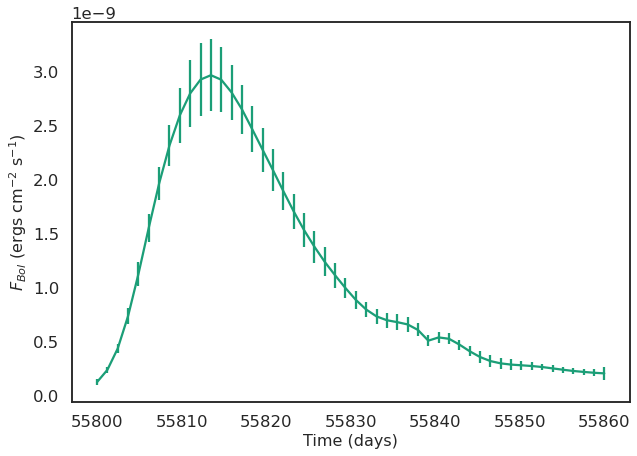

In [110]:
fig = plt.figure(figsize=(10,7)); 
ax = fig.gca()
bol_lum = np.array(bol)
#bol_std = np.array(bolerr)

plt.errorbar(X_new, bol_lum, yerr=bol_std*bol_lum,fmt='-')
plt.xlabel("Time (days)",fontsize=16);
plt.ylabel(r"$F_{Bol}$ (ergs cm$^{-2}$ s$^{-1}$)",fontsize=16);


Text(0.5, 1.0, 'SN2011fe Bolometric Luminosity')

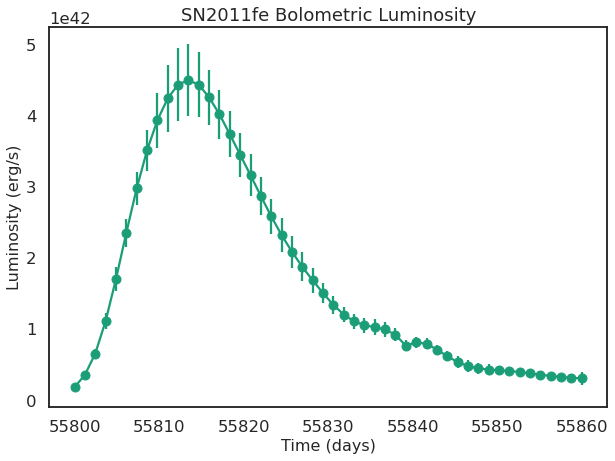

In [126]:
fig = plt.figure(figsize=(10,7)); 
ax = fig.gca()
bol_lum = np.array(bol)*4*np.pi*(3.56*3.086*10**24)**2

plt.errorbar(X_new, bol_lum, yerr=bol_std*bol_lum,fmt='o-')
plt.xlabel("Time (days)",fontsize=16);
plt.ylabel("Luminosity (erg/s)",fontsize=16);
plt.title('SN2011fe Bolometric Luminosity')

In [163]:
Tsig=(bol_lum/(4*np.pi*(3.56*3.086*10**14)**2*5.67*10**(-5)))**0.25

Terrsig=(bol_lum*bol_std/(4*np.pi*(3.56*3.086*10**14)**2*5.67*10**(-5)))**0.25

Text(0.5, 1.0, 'Temperature estimate (Stefan-Boltzmann law fit)')

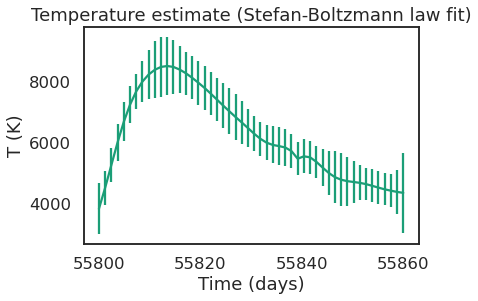

In [167]:
plt.errorbar(X_new,Tsig,yerr=Tsig*bol_std)
plt.xlabel("Time (days)")
plt.ylabel("T (K)")

plt.title('Temperature estimate (Stefan-Boltzmann law fit)')

In [160]:
def bb(lamb, T):
    h = 6.62607e-27 #cm^2 * g / s
    c = 2.99792458e10 #cm/s
    kB = 1.38064852e-16 # cm^2 * g / s^2 / K
    
    lam_cm = lamb * 1.e-8
    
    R=1e15

    # Calculate Radiance B_lam, in units of (erg / s) / cm ^ 2 / cm
    B_lam = ((2 * np.pi * h * c ** 2) / (lam_cm ** 5)) / (np.exp((h*c)/(lam_cm*kB*T)) - 1)

    Radiance = B_lam * 4*np.pi*R**2 / 1.e8 #(erg / s) / Angstrom

    return Radiance


In [161]:
from scipy.optimize import curve_fit

T = []
#R = []
Terr = []
#Rerr = []
for i in np.arange(len(flux_arr)):
    fluxes = flux_arr[i]
    specific_luminosity = fluxes * 4 * np.pi * (3.56*3.086*10**24)**2 #ergs s^-1 Angstroms^-1
    ferr = specific_luminosity * magserr_arr[i]
    BBparams, covar = curve_fit(bb,wavelengths[np.argsort(wavelengths)],specific_luminosity[np.argsort(wavelengths)],p0=(10000),sigma=ferr[np.argsort(wavelengths)],bounds=(0., [1.e6]))
    perr = np.sqrt(np.diag(covar))

    T.append(BBparams[0])
    #R.append(BBparams[1])
    Terr.append(perr[0])
    #Rerr.append(perr[1])

Text(0.5, 1.0, 'Temperature estimate (blackbody fit)')

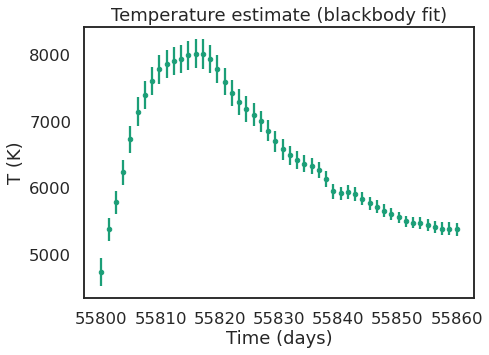

In [162]:

plt.figure(figsize=(7,5))
plt.errorbar(X_new, T, yerr=Terr, fmt='.');
plt.xlabel("Time (days)")
plt.ylabel("T (K)")

plt.title('Temperature estimate (blackbody fit)')

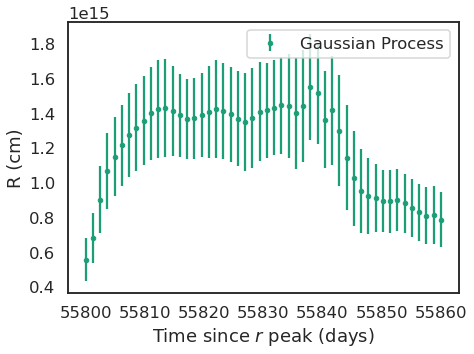

In [123]:
plt.figure(figsize=(7,5))

plt.errorbar(X_new, R, yerr=Rerr, fmt='.', label=r'Gaussian Process');
plt.xlabel(r"Time since $r$ peak (days)")
plt.ylabel(r"R (cm)")
plt.legend()
plt.savefig("Radius_vs_Superbol_Alex.png", bbox_inches='tight')